# Setup

En este notebook utilizaremos un [dataset](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python) que contiene información de clientes para intentar generar distintas segmentaciones de acuerdo a sus ingresos y algunos datos demográficos, luego intentaremos interpretarlas. Haremos uso de dos técnicas: **Clustering Jerárquico** y **DBScan**.

[*Fuente.*](https://www.kaggle.com/code/micheldc55/cluster-jer-rquico-y-dbscan-customer-segmentation)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [2]:
!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python
!unzip customer-segmentation-tutorial-in-python.zip

Dataset URL: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
License(s): other
  0% 0.00/1.55k [00:00<?, ?B/s]
100% 1.55k/1.55k [00:00<00:00, 2.53MB/s]
Archive:  customer-segmentation-tutorial-in-python.zip
  inflating: Mall_Customers.csv      


Vamos a cargar los datos recién descargados. Intentaremos hacer un análisis exploratorio rápido de los datos, pero el foco de este notebook será en explicar cómo funcionan estos dos métodos.

In [3]:
df = pd.read_csv('./Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


El dataset parece tener pocos valores, por lo que es ideal para el clustering jerárquico como veremos a continuación. Vemos que **no hay valores nulos** y que a priori no parece haber outliers en ninguna variable excepto Annual Income, aunque esto es solo una observación y debemos validarlo.

# Clustering Jerárquico

El clustering jerárquico es un método de **aprendizaje no supervisado** utiliza las distancias entre puntos/sub-clusters para generar una jerarquía entre los distintos elementos del dataset. Es un tipo de agrupación de los datos basado en alguna medida de distancia que debemos definir.

El elemento principal que utilizaremos para visualizar los resultados del clustering jerárquico es el **dendrograma**. El dendrograma muestra las relaciones de distancia entre los datos en un esquema visualmente muy fácil de interpretar.


![GIF de ejemplo](https://dashee87.github.io/images/hierarch.gif)

[Fuente.](https://ejemplo.com/imagen.gif)

<!-- <img src="attachment:14a40c22-6e4b-4711-a2d2-d182db3c6d47.png" width="400px" height="400px"> -->

El dendrograma es una estructura similar a un árbol genealógico en el que veremos representada esta medida de "similitud" entre distintos puntos o subclusters del dataset. Generalmente la similitud será alguna medida de distancia, como puede ser la distancia euclídea. Cuanto mayor sea la línea que conecta dos puntos, mayor será la distancia entre clusters/puntos.

## Construcción del dendrograma:

La diferencia entre un dendrograma y un árbol genealógico normal, es que las "ramas" del dendrograma **no** están ubicadas a intervalos regulares de arriba hacia abajo, sino que **las ramas serán más largas cuanto mayor sea la distancia** entre lo que se esté conectando debajo (puntos o sub-clusters).

A medida que **bajamos** por las ramas, **los clusters se irán subdividiendo** hasta llegar a una granularidad de un dato por cluster. Si nos desplazamos en la dirección contraria (**de abajo hacia arriba**) partiremos de los datos individuales e **iremos construyendo clusters a partir de la unión de los distintos puntos**, siempre basándonos en la medida de distancia que hayamos determinado.

<!-- <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124157811000091-f09-04-9780124157811.jpg" width="400px" height="400px">

`Fuente.` -->

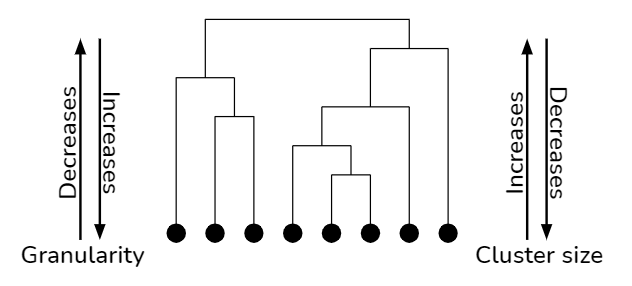

## Cómo determinar el número de clusters?

La ventaja del método de clustering jerárquico en lugar de otros métodos de clustering es que la forma de construcción del diagrama (dendrograma) nos permite obtener todos los posibles clusters y elegir el punto de corte por nuestra cuenta.

Es importante aclarar que cada línea horizontal de corte de un dendrograma marcará una cantidad de clústers distintos a realizar, y la cantidad de clusters estará marcada por la cantidad de líneas verticales que cruce la línea horizontal. Si vemos la imagen debajo notaremos que si cortamos de la línea horizontal hacia abajo, la línea toca 4 líneas verticales, por lo que estaremos separando en 4 clusters, tal cual se muestra en la imagen de la derecha.



![](https://miro.medium.com/v2/resize:fit:740/1*VvOVxdBb74IOxxF2RmthCQ.png)

[Fuente.](https://miro.medium.com/v2/resize:fit:740/1*VvOVxdBb74IOxxF2RmthCQ.png)

Muy bien pero aún no hemos determinado el número óptimo de clusters... El **número óptimo de clusters** se determina por la **mayor distancia** que podamos recorrer en el eje **y** sin encontrarnos con un **punto de quiebre**.
¿Por qué hacemos esto? Porque la mayor altura sin puntos de corte implica la mayor **separación** entre clusters, que se puede interpretar como la mayor **disimilitud**.

## Medidas de distancia

Existen múltiples maneras de medir la distancia entre clusters/puntos, cada una con sus ventajas y desventajas. Las formas de medir distancia se suelen llamar **linkage** (unión en inglés). En general hay 4 métodos habituales para calcular esa distancia:

- **Complete-linkage:** Este método consiste en calcular la distancia entre clusters como la máxima distancia posible entre clusters. Básicamente, tomar todos los puntos de cada cluster y quedarnos con la distancia máxima entre ellos.
    - *Ventajas*: Los métodos de complete-linkage son menos sensibles al ruido y outliers. Los algoritmos que utilizan este método son buenos para separar clusters incluso cuando hay ruido entre ellos.
    - *Desventajas*: Los métodos de complete-linkage tienden a romper grandes clusters y tienen una tendencia natural a formar clusters globulares

- **Single-linkage:** Este método toma el enfoque opuesto. En este caso la distancia entre clusters se calculará como la mínima distancia entre puntos del cluster.
    - *Ventajas*: Permiten manejar formas no elípticas y permiten capturar clusters de distintos tamaños.
    - *Desventajas*: Son muy sensibles a ruido y outliers.

- **Average-linkage:** La distancia entre clusters se calculará como la distancia promedio entre todas las distancias entre clusters. Se calculan las distancias entre todos los puntos de un cluster con todos los puntos del otro y se toma la media.
    - *Ventajas*: El método funciona bien para separar clusters de datos incluso cuando hay ruido.
    - *Desventajas*: El método tiende a generar clusters globulares.

- **Centroid-linkage:** Se encuentra el centroide de cada cluster y se toma la distancia entre cenrtoides.
    - *Ventajas*: También funciona bien cuando hay ruido entre clusters.
    - *Desventajas*: El método tiende a generar clusters globulares.

Y hay otras más como [Ward](https://en.wikipedia.org/wiki/Ward%27s_method).

![image](https://drek4537l1klr.cloudfront.net/rhys/v-7/Figures/CH17_FIG_3_MLR.png)

## Cómo se generan los clusters?

Existen **dos métodos** para generar clusters utilizando clustering jerárquico:

- Método **aglomerativo**
- Método **divisivo**

### Método aglomerativo:

El método aglomerativo parte de la mayor subdivisión posible de los datos: que cada dato sea un cluster. Luego comienza a unir uno a uno los puntos del dataset por la medida de distancia que hayamos elegido.

En el primer paso se crea un cluster con los dos puntos más cercanos, luego se miden las distancias entre todos los puntos y también con el nuevo cluster (utilizando la medida de distancia que hayamos elegido). En el próximo paso se unen los dos elementos de menor distancia (pueden ser dos puntos o punto y cluster). Continuamos con este proceso hasta que solamente quede un cluster.

### Método divisivo:

El método divisivo es exactamente lo contrario al método aglomerativo. Partimos de un cluster que contiene todos los datos y comenzamos a subdividirlo en dos cluster, buscando subdividir en los dos clusters que menos se parezcan (basados en una medida de distancia).

**¿Cómo se selecciona el cluster "menos" parecido?** Se selecciona calculando la **SSE** (suma de errores cuadrados) al **centroide** de cda cluster. El cluster que tenga el mayor valor de SSE será el que se subdivida en el siguiente paso.

### Comparando métodos Divisivos y Aglomerativos:

- El clustering divisivo es **más complejo** en términos de aplicación, porque debemos ejecutar otro algoritmo para subdividir los clusters dentro del algoritmo divisivo.
- El clustering divisivo es **más eficiente** que el aglomerativo porque partimos de los datos en su totalidad, por lo que estamos teniendo en cuenta información del dataset entero desde el inicio. Si pensamos en el método aglomerativo, partimos de cada punto del dataset como un cluster y construimos sobre eso, por lo que no tenemos esa perspectiva general de la distribución de los datos. El aglomerativo toma decisiones basadas en información más local de los datos.

# Aplicando clustering jerárquico

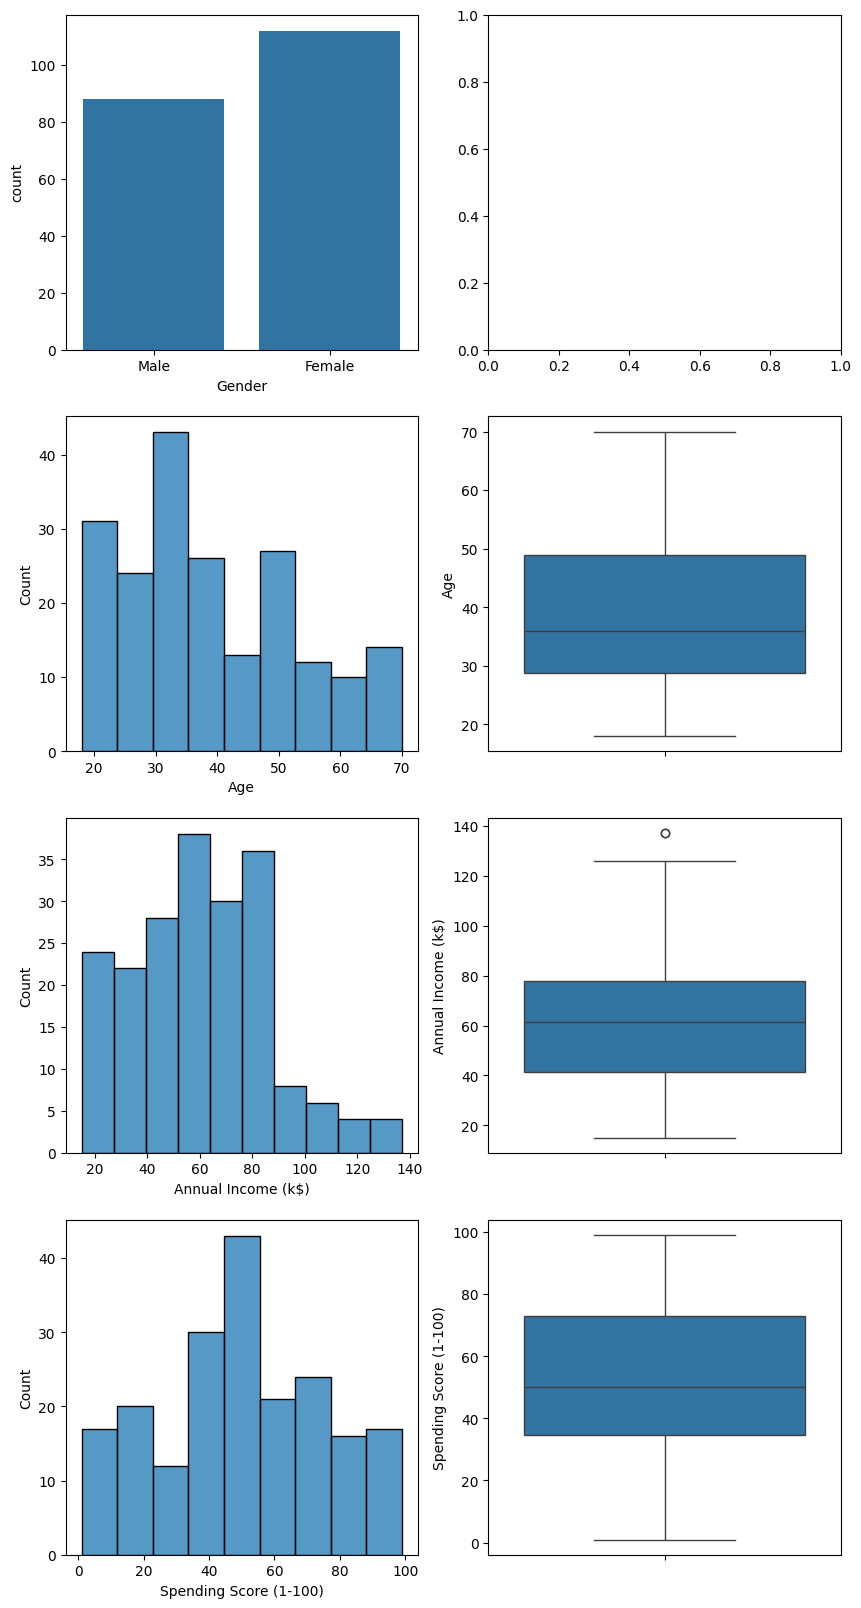

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
selected_columns = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for idx, column in enumerate(selected_columns):
    if column == 'Gender':
        sns.countplot(data=df, x=column, ax=ax[idx][0])
    else:
        sns.histplot(data=df, x=column, ax=ax[idx][0])

    if column == 'Gender':
        pass
    else:
        sns.boxplot(data=df, y=column, ax=ax[idx][1])

**Dos cosas deberían llamar nuestra atención**. La primera es que la **variable de género está un poco sesgada** hacia mujeres (hay más mujeres que hombres en el dataset). No lo utilizaremos en este caso, pero puede ser interesante utilizar [undersampling o oversampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) para **balancear las clases**. Como no estamos intentando predecir nada, esto no será demasiado importante, pero sí podemos tenerlo en cuenta si vemos que el modelo que entrenemos prioriza un género sobre otro.

La segunda es que algunas variables no tienen distribución normal. Esto puede ser problemático si queremos generar clusters que no son globulares, porque debemos tener en cuenta la métrica de distancia que utilicemos para agrupar a nuestros clientes. Ahora nos interesa estudiar los datos con un análisis bivariable (analizando cómo se comportan las variables entre sí).

In [7]:
df['Gender'].dtype == np.dtype('object')

True

Vamos a graficar todas las combinaciones de variables de par en par. Para las que sean numéricas además agregaremos la separación por género, para ver si podemos identificar algún insight interesante sobre los datos.

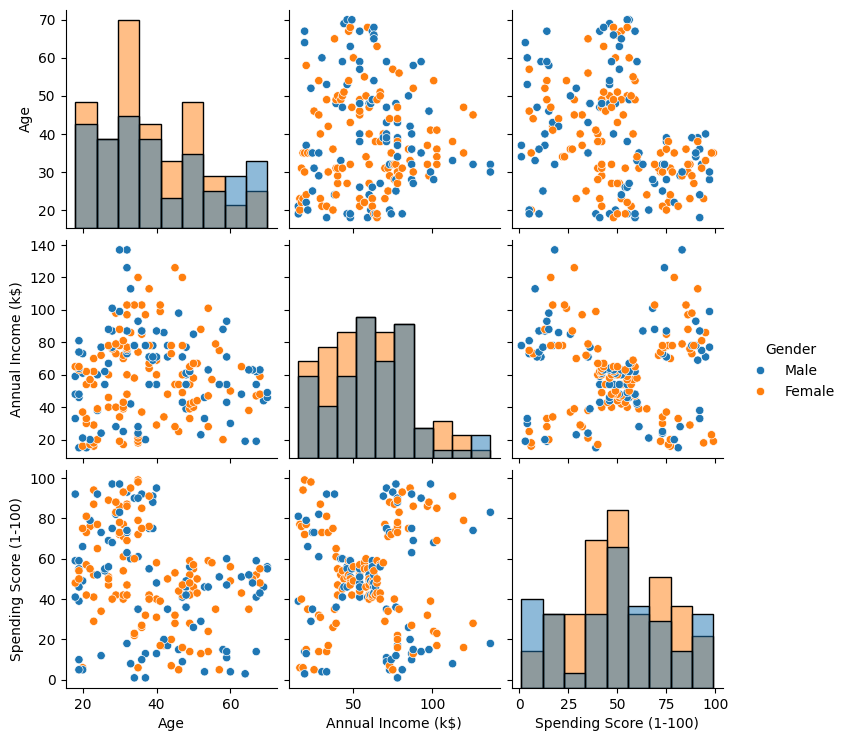

In [38]:
sns.pairplot(df, x_vars=['Age','Annual Income (k$)','Spending Score (1-100)'], y_vars=['Age','Annual Income (k$)','Spending Score (1-100)'], hue='Gender', diag_kind='hist')
plt.show()

No parece haber una **diferencia sustancial entre hombres y mujeres**, al menos visualmente. Pero en los histogramas no podemos definirlo únicamente utilizando el método visual, así que utilizaremos un método estadístico para determinar si los dos histogramas que vemos provienen de la misma distribución. Existen muchos tests para determinar esto, algunos de ellos -8y su implementación) se pueden ver [aquí](https://towardsdatascience.com/how-to-compare-two-or-more-distributions-9b06ee4d30bf). Recordar que lo que queremos deducir es si existe alguna diferencia observable entre el ingreso y spending score entre hombres y mujeres (acotado al scope del dataset). Pero lo importante es que debemos elegir algún test **relevante** para determinar si las variables numéricas provienen de la misma distribución para hombres y mujeres. Utilizaremos los tests de **Kolmogorov-Smirnov** y **Chi-cuadrado** para verificar si podemos asumir que la distribución de gasto/ingresos de hombres y mujeres proviene de la misma distribución.

<Axes: >

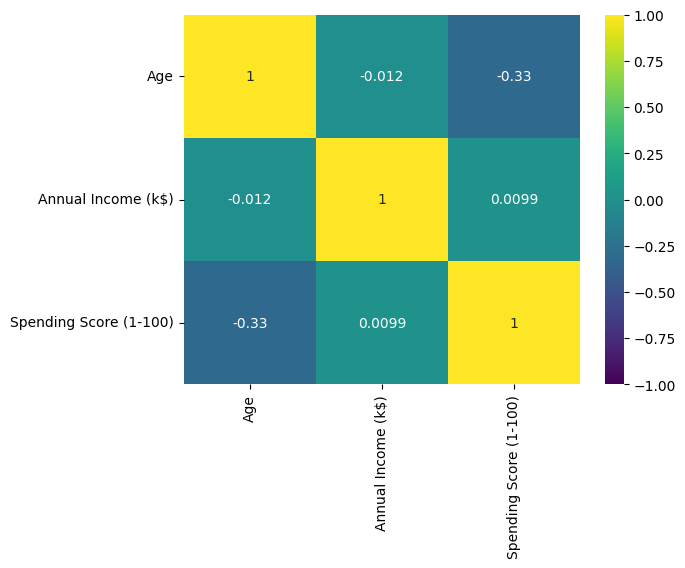

In [10]:
correlation_df = df.drop(columns =['Gender','CustomerID'], axis=1).corr(numeric_only=True)
correlation_df

sns.heatmap(correlation_df, vmin=-1, vmax=1, annot=True, cmap='viridis')

## Primer clustering

In [11]:
df_jer = df.drop(['CustomerID'], axis=1)
df_jer.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [12]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler, LabelEncoder

(200, 3)


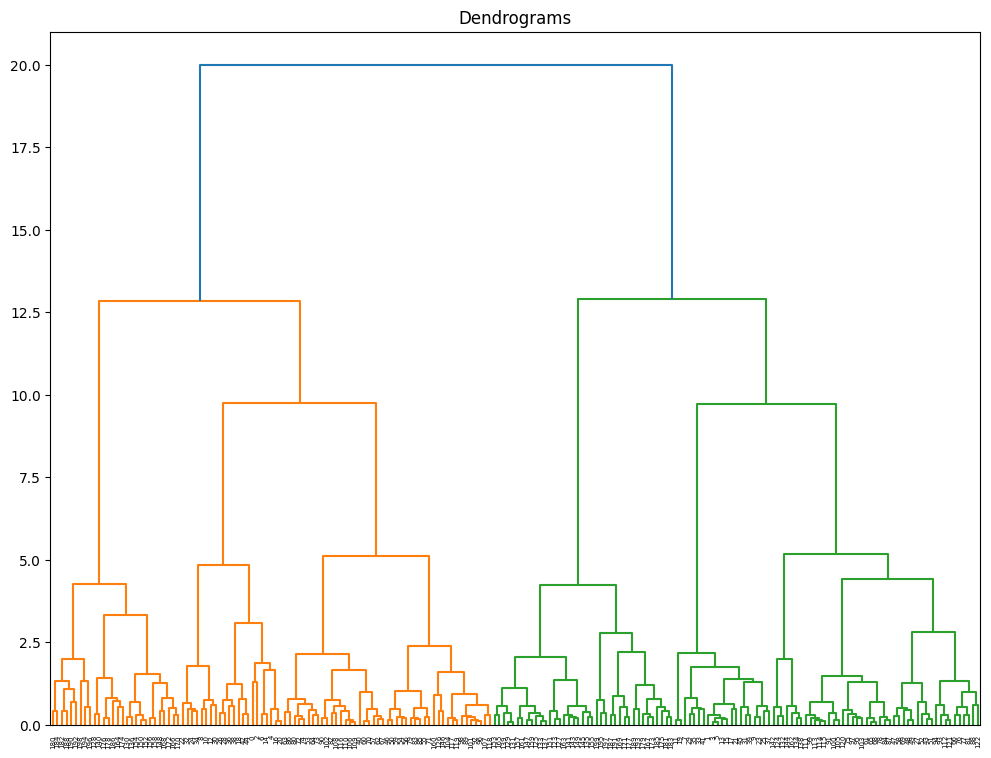

In [48]:
scaler = StandardScaler()

df_dendro = df_jer.drop(['Gender'], axis=1).copy()
df_escalado = scaler.fit_transform(df_dendro)
print(df_escalado.shape)
plt.figure(figsize=(12, 9))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df_escalado, method='ward'))

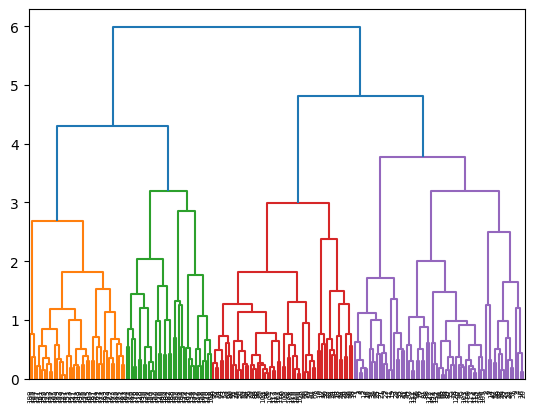

In [15]:
dend = shc.dendrogram(shc.linkage(df_escalado, method='complete'))

In [16]:
df_escalado_full = pd.DataFrame(df_escalado, columns=['Age','Annual Income (k$)','Spending Score (1-100)'])
df_escalado_full

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


In [49]:
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
agg_cluster.fit_predict(df_escalado)

array([4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0,
       4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 0,
       4, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 0, 2, 1, 2, 3, 2, 3, 2,
       0, 2, 0, 2, 3, 2, 0, 2, 3, 2, 0, 2, 0, 2, 1, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 1, 2, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2])

<Figure size 1000x700 with 0 Axes>

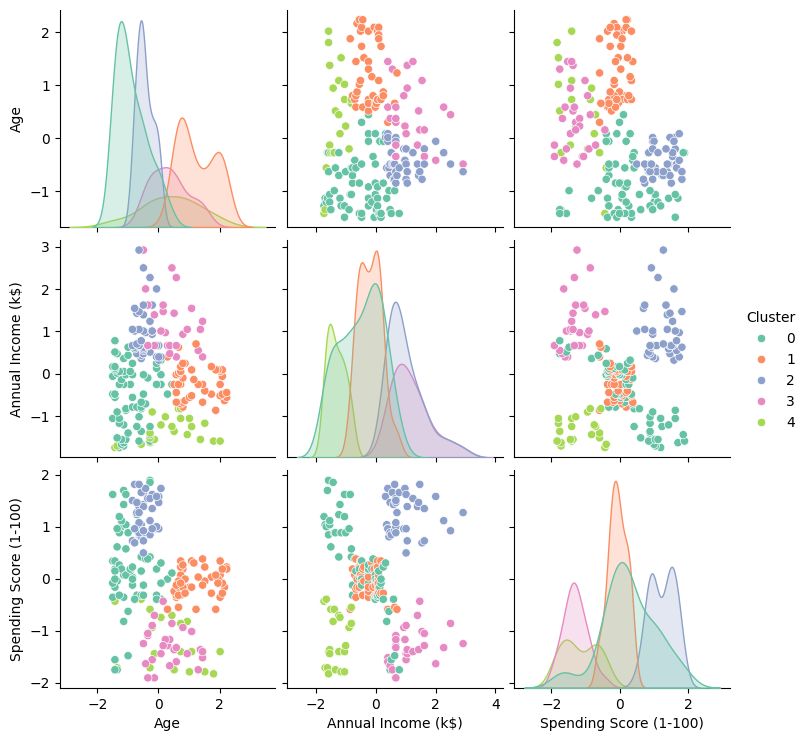

In [50]:
df_escalado_full['Cluster'] = agg_cluster.labels_
plt.figure(figsize=(10, 7))
sns.pairplot(data=df_escalado_full,
             hue='Cluster',
             palette='Set2')
plt.show()

#### Utilizando los Sillhouette scores para seleccionar el número de clusters:

Generalmente cuando utilizamos un dendrograma, solemos tomar la altura máxima entre bifurcaciones como la forma de determinar la cantidad de clusters. El problema de este proceso es que la distancia entre clusters en los métodos aglomerativos está muy sesgada a los datos iniciales, y reflejan poco los datos agregados. Por esto, una buena forma de validar si los resultados son correctos es con un gráfico de **Silhouette Score**. El **Silhouette Score** es una métrica que evalúa qué tan bien se agrupa cada punto de datos dentro de su cluster en comparación con otros clusters. Se basa en dos medidas:

- **Cohesión**: Qué tan cerca está un punto de datos de los demás puntos de su propio cluster.
- **Separación**: Qué tan lejos está un punto de datos de los puntos del cluster más cercano.

El **Silhouette Score** para un punto $i$ se calcula como:

$$S(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

Donde:

- $a(i)$ es la distancia promedio entre $i$ y todos los demás puntos de su propio cluster.
- $b(i)$ es la distancia promedio entre $i$ y todos los puntos del cluster más cercano al que no pertenece.

Para cada cantidad de clusters graficaremos también las primeras dos componentes principales.


For n_clusters = 2 The average silhouette_score is : 0.31795733680759597
For n_clusters = 3 The average silhouette_score is : 0.32148866683112387
For n_clusters = 4 The average silhouette_score is : 0.3614512741691407
For n_clusters = 5 The average silhouette_score is : 0.39002826186267214


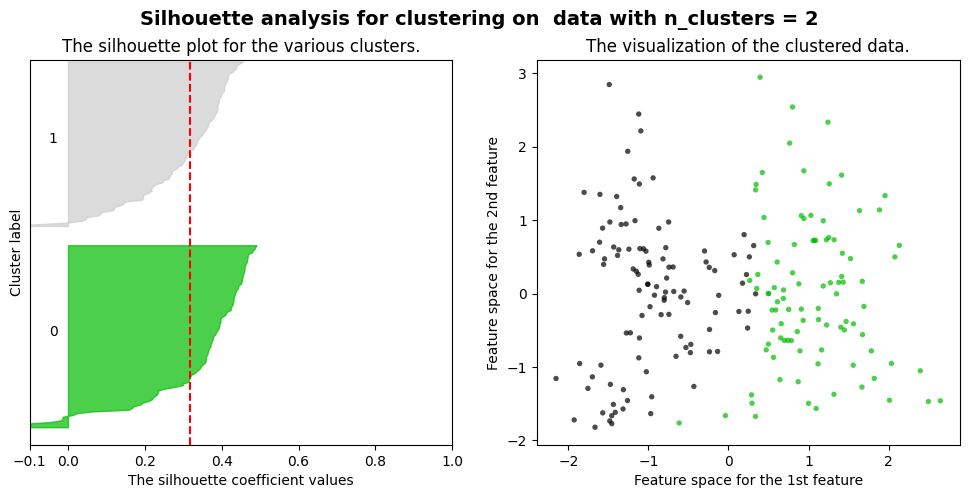

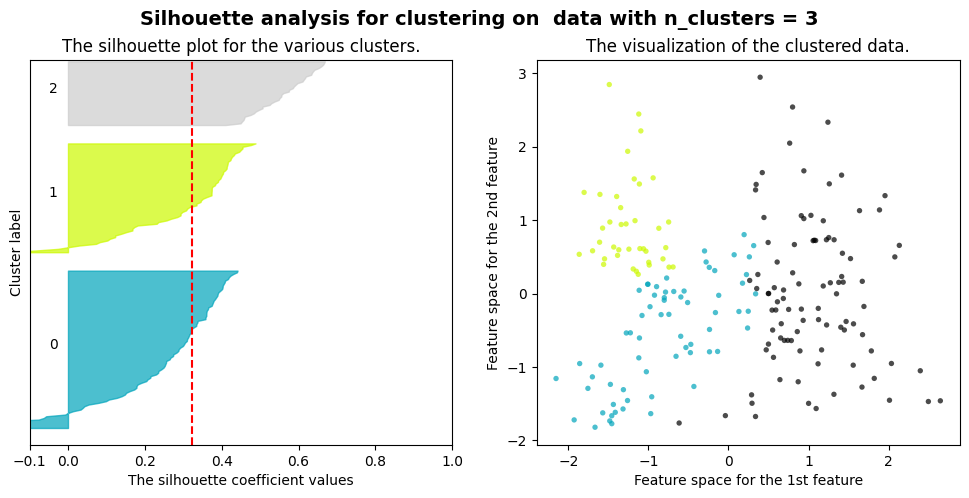

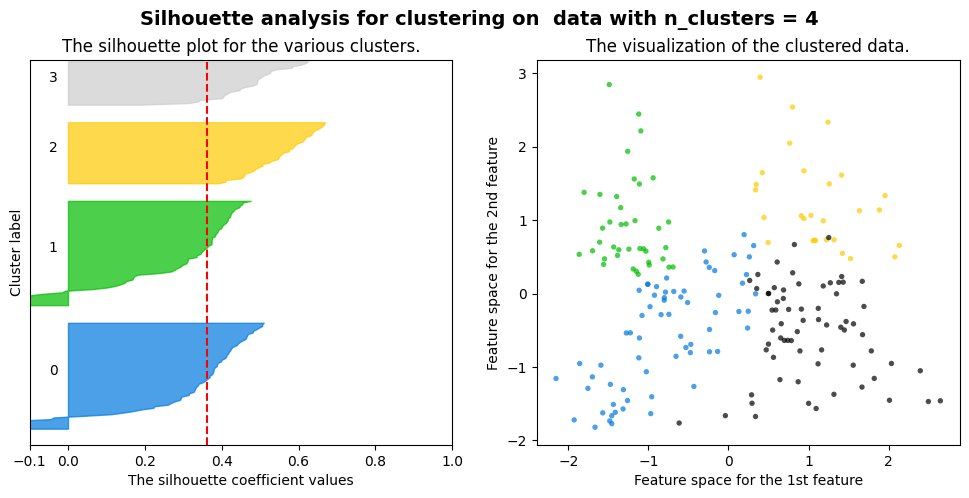

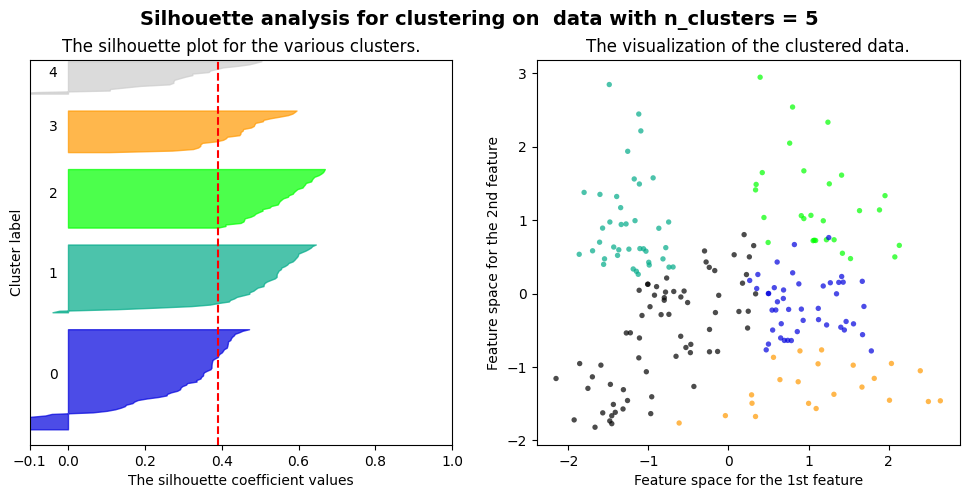

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm
from sklearn.decomposition import PCA

#PCA with two principal components
pca = PCA(n_components=2)
PCA_2d = pca.fit_transform(df_escalado)

for n_clusters in range(2, 6):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_escalado) + (n_clusters) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.

    clusterer = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = clusterer.fit_predict(df_escalado)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_escalado, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_escalado, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i+1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float)) / n_clusters)
    ax2.scatter(PCA_2d[:, 0], PCA_2d[:, 1], marker='.', s=60, lw=0, alpha=0.7,
                c=colors, edgecolor='k')



    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for clustering on  data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Vemos que éste método no es muy bueno ni claro a la hora de seleccionar clusters que puedan sernos útiles. Esto es porque el método aglomerativo es bastante malo para generalizar a partir de los datos iniciales y por lo tanto necesitamos muchos clusters para comenzar a ver un buen resultado en términos de **cohesión** y **separación entre clusters**.

# DBScan

Hasta ahora hemos visto algoritmos de clustering basados en distancia como K-Means y clustering Jerárquico. Muchos problemas pueden resolverse únicamente utilizando estos dos métodos, pero ambos tienen un **problema inherente: no pueden generar clusters de cualquier geometría**. Esto, que puede parecer trivial, es una limitante muy grande ya que nuestros clusters muchas veces no estarán definidos por la medida de distancia, y puede ser más interesante tomar alguna otra medida característica, como la **densidad**.

Debajo se muestra un claro ejemplo de una situación en la que debemos utilizar un método que no forme clusters globulares. Si tenemos datos distribuidos en forma de diana como en la imagen debajo, los métodos globulares fallarán porque intentarán colocar los centroides equidistantes por la simetría del problema.

![imagen](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/db7-1.png)

En este caso, necesitamos otro tipo de algoritmo en el que influya la densidad de puntos en lugar de la distancia exclusivamente. Aquí es donde el algoritmo de **DBScan** se vuelve muy útil. Otra gran ventaja del algoritmo de DBScan es que permite aglomerar el ruido o valores atípicos como otro cluster, ya que no estarán cerca de ningún cluster denso.

![imagen](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/db6-e1584577503359.png)

[Fuente.](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/)


## Cómo funciona

DBScan es un acrónimo de **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise. El algoritmo agrupa los datos que se encuentran formando agrupaciones densas, identificando clusters de múltiples geometrías al enfocarse en la **densidad local** de los datos. El algoritmo de DBScan también es robusto a outliers, por lo que es una excelente opción si este tipo de datos está presente en nuestro dataset. Finalmente, DBScan tampoco necesita que se especifique el número de clusters de antemano, sino que lo determinará basándose únicamente en la densidad de los puntos.



El algoritmo requiere únicamente de 2 parámetros: **epsilon** y **minPoints**. Este modelo se basa en crear círculos/esferas centrados en cada uno de los puntos del dataset y contar cuantos datos caen dentro del mismo. En este contexto, **epsilon** es el **radio de la circunferencia/esfera**, y **minPoints** es la **cantidad de puntos que deben estar contenidos en la circunferencia/esfera**.


![gif](https://dashee87.github.io/images/DBSCAN_search.gif)

### Cómo se conectan los puntos:

Se definen 3 tipos distintos de puntos:
1) **Core Points:** Son puntos que tienen una cantidad de puntos **mayor o igual** a **minPoints** a un radio de **epsilon**.

2) **Non-Core Points:** Son puntos que tienen al menos una conexión pero **no son Core Points**.

3) **Outliers:** Son puntos que no tienen conexión con ningún punto del dataset.

En el **primer paso** de la iteración, se calcula, para todos los puntos del dataset, cuantos puntos tienen en su proximidad a una distancia menor o igual a **epsilon**.

En el **segundo paso**, se selecciona un **Core Point** aleatoriamente y se conecta a todos los demás Core Points que se pueda conectar. Diremos que dos **Core Points se pueden conectar** si están a una distancia menor a epsilon y ambos son Core Points.

En el **tercer paso** de la iteración se elije otro Core Point que no esté en el conjunto previamente seleccionado y se repite el paso 2. Se continúa hasta que **no queden Core Points sin asignar**. Al final de este proceso se han conectado todos los Core Points entre sí, formándose tantos clusters como conjuntos no conexos haya.

Una vez concluido este paso, se asignan los puntos que sean **Non-core** que estén a una distancia menor a epsilon de algún cluster. Esto se hace en el mismo orden en que se propagaron los Core Points, por lo que si un punto está a una distancia menor a epsilon de dos clusters, ese punto se asignará al cluster que se haya generado primero.

La diferencia entre estos puntos y los anteriores es que no propagaremos estos puntos hacia otros puntos Non-core, simplemente los puntos que estén próximos a un cluster se asignarán a ese cluster siguiendo el orden, pero si hubiera un punto a una distancia menor a epsilon del Non-core pero que está a una distancia mayor a epsilon del punto más cercano del cluster, ese punto no se agrega al cluster.

Finalmente, el **último paso** es asignarle a todos los puntos que sean **Non-core** y que no hayan sido asignados a ningún cluster un cluster adicional, el de los **outliers**.

### Cómo definir epsilon y minPoints

#### Epsilon

No existe un método analítico para obtener el número correcto para epsilon y minPoints, pero sí existen algunas heurísticas que pueden simplificarnos para definir los valores iniciales. Podemos definir el **epsilon** a partir de la curva de codo de la distribución de distancias entre los puntos del dataset y su punto más cercano para todos los puntos. Podemos obtener fácilmente este resultado utilizando el método de K-Nearest Neighbors (aún no lo hemos visto en este curso, pero básicamente calcula las distancias de todos los N puntos del dataset con todos los N-1 restantes para quedarse con los K más cercanos).

In [20]:
df_dbscan = df.drop(['Gender'], axis=1).copy()
df_dbscan.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,2,21,15,81
2,3,20,16,6
3,4,23,16,77
4,5,31,17,40


In [21]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors=2)
knn = model.fit(df_dbscan)
distances, indices = knn.kneighbors(df_dbscan)

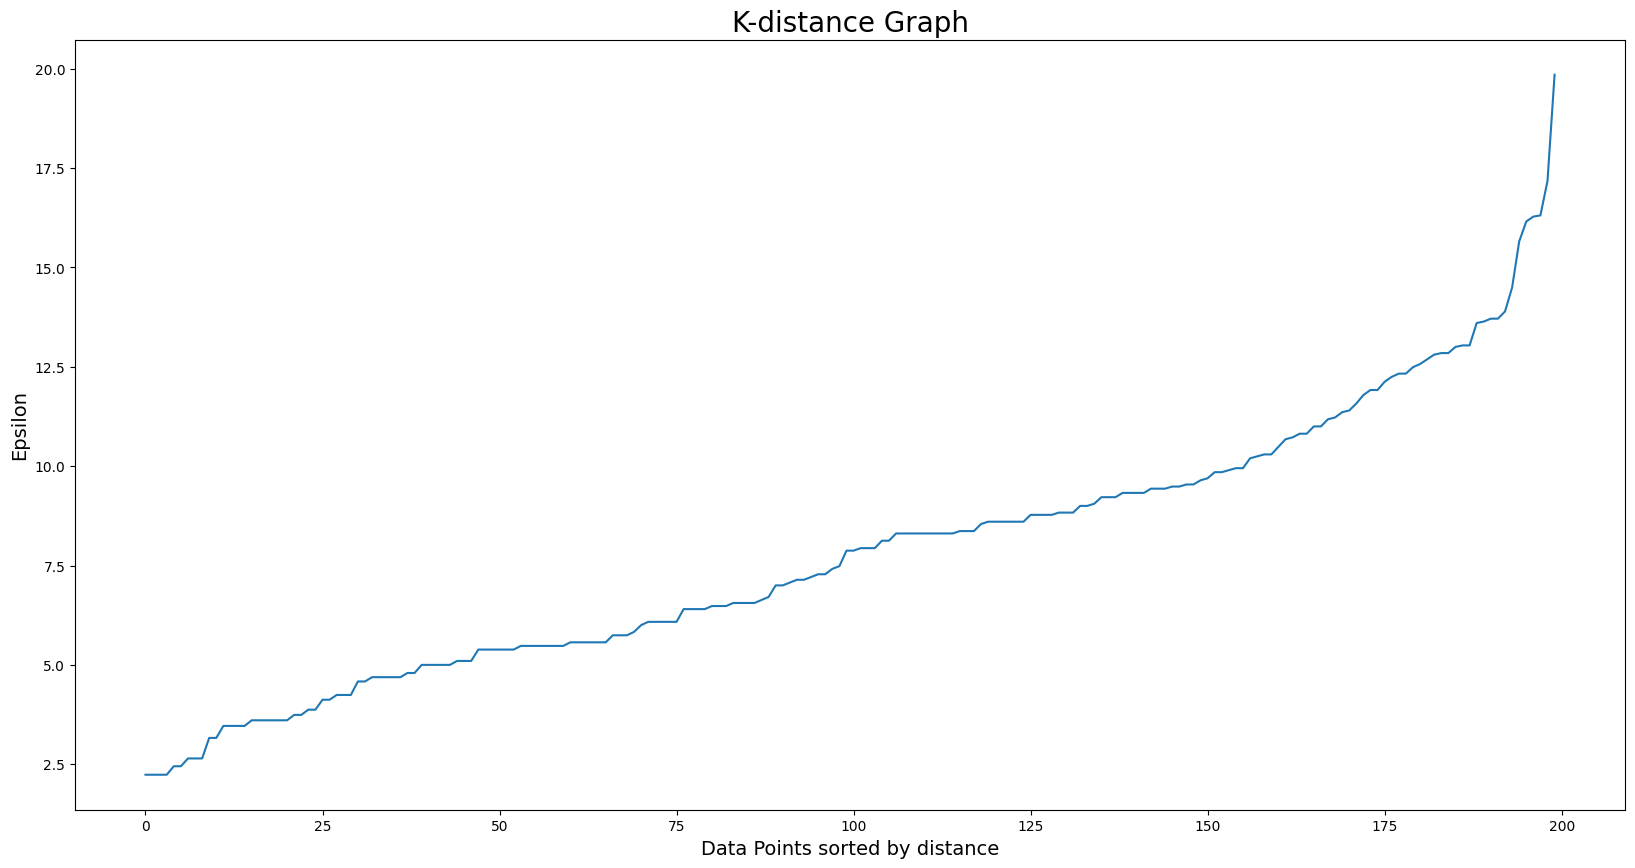

In [22]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Por la imagen, vemos que el valor de epsilon debería estar cerca de 0.6 (el codo de la curva). La distribución parece un poco escalonada porque hay pocos datos en el dataset, tener en cuenta que el dataset entero apenas tiene 200 clientes. Tomaremos **epsilon = 0.6** como valor inicial.

#### minPoints

Para definir el valor de minPoints debe ser necesariamente mayor a uno, o todos los puntos tendrán al menos un punto cercano y en el peor caso todos serán un cluster. Se recomienda que el valor de minPoints sea al menos la cantidad de features + 1. Por lo que en este caso tomaremos **minPoints = 5** como valor inicial. Como regla general, **se suele partir de minPoints = 2 * "número de features"**.

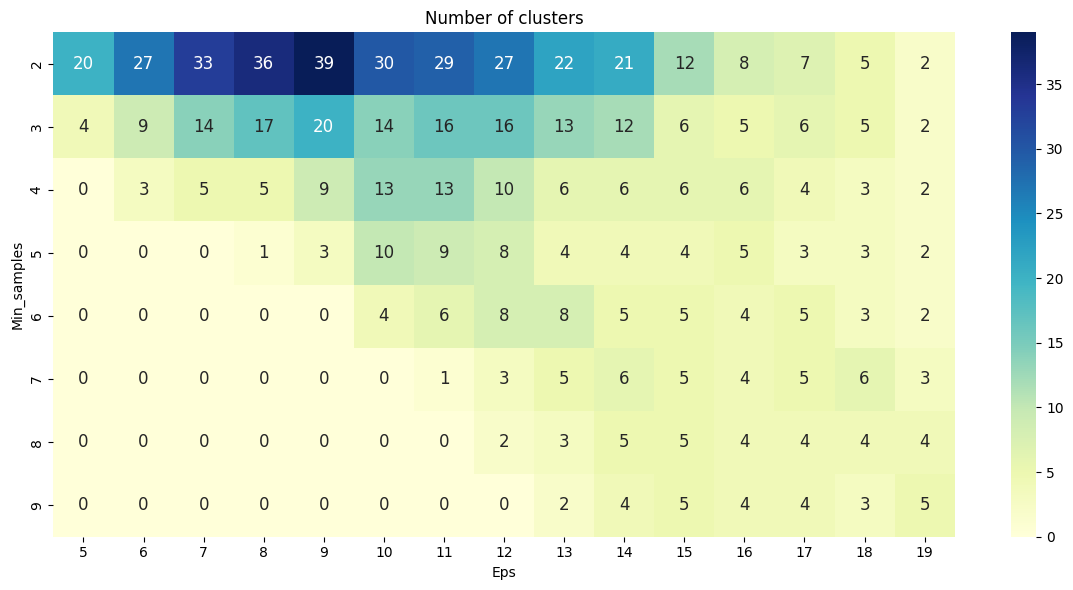

,Eps,Min_samples,No_of_clusters,Silhouette_score
0,5,2,20,-0.443413
1,5,3,4,-0.410465
2,5,4,0,NaN
3,5,5,0,NaN
4,5,6,0,NaN
...,...,...,...,...
115,19,5,2,0.223631
116,19,6,2,0.195719
117,19,7,3,0.334904
118,19,8,4,0.169658


In [26]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

# Excluir CustomerID
# df_reconstruido = df_dbscan.drop(columns=['CustomerID'])
df_reconstruido = df_dbscan.copy()

eps_values = np.arange(5, 20, 1)  # eps values to be investigated
min_samples = np.arange(2, 10, 1)  # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

no_of_clusters = []
sil_score = []

for eps, min_samples in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_reconstruido)
    labels = DBS_clustering.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise points
    no_of_clusters.append(n_clusters)

    if n_clusters > 1:  # Calculate Silhouette Score only if there is more than one cluster
        sil_score.append(silhouette_score(df_reconstruido, labels))
    else:
        sil_score.append(np.nan)

# Crear DataFrame con los resultados
tmp = pd.DataFrame(DBSCAN_params, columns=['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters
tmp['Silhouette_score'] = sil_score

# Crear la tabla pivot para número de clusters
pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

# Graficar heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 12}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.tight_layout()
plt.show()

# Mostrar DataFrame con Eps, Min_samples y Silhouette Score
display(tmp[['Eps', 'Min_samples', 'No_of_clusters', 'Silhouette_score']])


<ipython-input-32-4d40440fe4ec>:36: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(
<ipython-input-32-4d40440fe4ec>:44: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(
<ipython-input-32-4d40440fe4ec>:52: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(


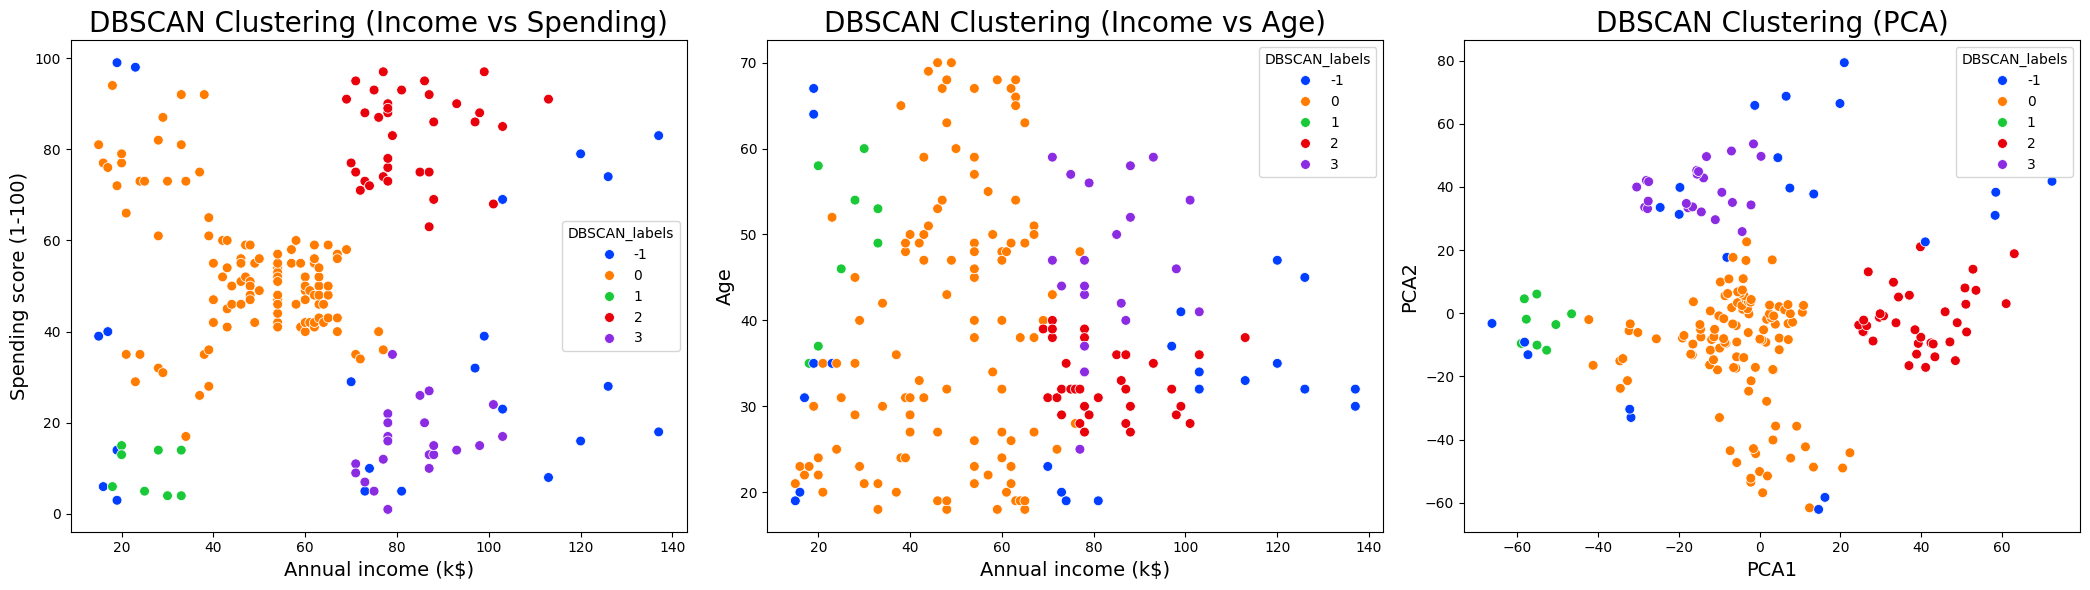

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Aplicar DBSCAN
dbscan = DBSCAN(eps=14, min_samples=6)
try:
    df_dbscan.drop(columns=['CustomerID'], inplace=True)
except KeyError:
    pass
dbscan.fit(df_dbscan)

df_reconstruido = pd.DataFrame(df_dbscan, columns=df_dbscan.columns)
df_reconstruido['DBSCAN_labels'] = dbscan.labels_

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_reconstruido.drop(columns=['DBSCAN_labels']))

# Agregar las componentes de PCA al DataFrame
df_reconstruido['PCA1'] = df_pca[:, 0]
df_reconstruido['PCA2'] = df_pca[:, 1]

# Crear la figura con 3 gráficos
fig, ax = plt.subplots(1, 3, figsize=(21, 6))

x = 'Annual Income (k$)'
y = 'Spending Score (1-100)'
z = 'Age'

palette = sns.color_palette("bright", 6)

# Gráfico 1: Ingreso anual vs Spending Score
sns.scatterplot(
    data=df_reconstruido, x=x, y=y, hue='DBSCAN_labels', palette=palette, s=50, ax=ax[0]
)
ax[0].set_title('DBSCAN Clustering (Income vs Spending)', fontsize=20)
ax[0].set_xlabel(x.capitalize(), fontsize=14)
ax[0].set_ylabel(y.capitalize(), fontsize=14)

# Gráfico 2: Ingreso anual vs Edad
sns.scatterplot(
    data=df_reconstruido, x=x, y=z, hue='DBSCAN_labels', palette=palette, s=50, ax=ax[1]
)
ax[1].set_title('DBSCAN Clustering (Income vs Age)', fontsize=20)
ax[1].set_xlabel(x.capitalize(), fontsize=14)
ax[1].set_ylabel(z.capitalize(), fontsize=14)

# Gráfico 3: PCA (Componentes principales)
sns.scatterplot(
    data=df_reconstruido, x='PCA1', y='PCA2', hue='DBSCAN_labels', palette=palette, s=50, ax=ax[2]
)
ax[2].set_title('DBSCAN Clustering (PCA)', fontsize=20)
ax[2].set_xlabel('PCA1', fontsize=14)
ax[2].set_ylabel('PCA2', fontsize=14)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [33]:
df_reconstruido.DBSCAN_labels.value_counts()

,count
DBSCAN_labels,
0,112
2,35
3,23
-1,22
1,8


## Conclusiones

Vemos que en este caso, los clusters obtenidos del método de DBScan no son muy buenos. Esto se debe principalmente a dos razones:
- La primera es la falta de datos. Tenemos apenas 200 datos y por lo tanto el margen de error es bastante alto.
- La segunda es que los datos son de relativa baja densidad en muchos casos, por lo que el algoritmo de DBSCAN tiene a fallar por no poder agrupar los datos correctamente.

# Ejercicio sugerido

Existen múltiples datasets al respecto para probar estas técnicas en un escenario similar con más datos o más features, por ejemplo: https://www.kaggle.com/datasets/datascientistanna/customers-dataset. Probar repetir el mismo análisis a ver que patrones encuentran!

In [ ]:
!kaggle datasets download -d datascientistanna/customers-dataset